# Model

## Imports

In [1]:
import os
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

In [2]:
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Constants & Utils

In [3]:
def int2date(date):
    date = str(date)
    year = date[:4]
    month = date[4:6]
    day = date[6:]
    return year + '-' + month + '-' + day

In [4]:
indicator_columns = [
    'C4_combined_numeric',
    'H6_combined_numeric',
    'H7_combined_numeric'
]

max_values = [4, 4, 5]

In [5]:
population = pd.read_excel('POPULATION.xlsx')
population_mappings = dict(zip(population['State'], population['Pop']))

## Data Preprocessing

### Import Data

In [6]:
df = pd.read_csv('OxCGRT_latest_combined.csv')
df = df[df['CountryName'] == 'United States'][['RegionName', 'Date', 'ConfirmedDeaths'] + indicator_columns].dropna(subset=['RegionName', 'Date', 'ConfirmedDeaths'])
df['Date'] = pd.to_datetime(df['Date'].apply(int2date))
df[indicator_columns] = pd.concat([df[col] / val for col, val in zip(indicator_columns, max_values)], axis=1).rename(columns=dict(zip(indicator_columns, ['GatheringRestriction', 'MaskMandate', 'VaccineMandate'])))
df = df.rename(columns=dict(zip(indicator_columns, ['GatheringRestriction', 'MaskMandate', 'VaccineMandate'])))
df

,RegionName,Date,ConfirmedDeaths,GatheringRestriction,MaskMandate,VaccineMandate
170877,Alaska,2020-01-22,0.0,0.0,0.000,0.0
170878,Alaska,2020-01-23,0.0,0.0,0.000,0.0
170879,Alaska,2020-01-24,0.0,0.0,0.000,0.0
170880,Alaska,2020-01-25,0.0,0.0,0.000,0.0
170881,Alaska,2020-01-26,0.0,0.0,0.000,0.0
...,...,...,...,...,...,...
205427,Wyoming,2021-11-02,1207.0,0.0,0.375,1.0
205428,Wyoming,2021-11-03,1243.0,0.0,0.375,1.0
205429,Wyoming,2021-11-04,1243.0,0.0,0.375,1.0
205430,Wyoming,2021-11-05,1243.0,0.0,0.375,1.0


### Feature Engineering

In [7]:
df['DailyDeaths'] = np.nan
df['DailyDeathsMA'] = np.nan
moving_average_window = 7

region_names = df['RegionName'].drop_duplicates()
df_regions = []
for region_name in region_names:
    df_region = df[df['RegionName'] == region_name]
    for i in range(1, len(df_region)):
        df_region.iloc[i, -2] = max(df_region.iloc[i, 2] - df_region.iloc[i - 1, 2], 0) / (df_region.iloc[i, 1] - df_region.iloc[i - 1, 1]).days
    df_region = df_region[1:]
    df_region['DailyDeathsMA'][(moving_average_window // 2):-(moving_average_window // 2)] = np.convolve(df_region['DailyDeaths'], np.ones(moving_average_window) / moving_average_window, 'valid')
    df_regions.append(df_region)
df = pd.concat(df_regions)
df['Population'] = df['RegionName'].map(population_mappings)
df

,RegionName,Date,ConfirmedDeaths,GatheringRestriction,MaskMandate,VaccineMandate,DailyDeaths,DailyDeathsMA,Population
170878,Alaska,2020-01-23,0.0,0.0,0.000,0.0,0.0,NaN,733391
170879,Alaska,2020-01-24,0.0,0.0,0.000,0.0,0.0,NaN,733391
170880,Alaska,2020-01-25,0.0,0.0,0.000,0.0,0.0,NaN,733391
170881,Alaska,2020-01-26,0.0,0.0,0.000,0.0,0.0,0.000000,733391
170882,Alaska,2020-01-27,0.0,0.0,0.000,0.0,0.0,0.000000,733391
...,...,...,...,...,...,...,...,...,...
205427,Wyoming,2021-11-02,1207.0,0.0,0.375,1.0,33.0,9.857143,576851
205428,Wyoming,2021-11-03,1243.0,0.0,0.375,1.0,36.0,9.857143,576851
205429,Wyoming,2021-11-04,1243.0,0.0,0.375,1.0,0.0,NaN,576851
205430,Wyoming,2021-11-05,1243.0,0.0,0.375,1.0,0.0,NaN,576851


## Visualization

In [8]:
df_date = df.groupby('Date').agg({'ConfirmedDeaths': 'sum', 'DailyDeathsMA': 'sum', 'GatheringRestriction': 'mean', 'MaskMandate': 'mean', 'VaccineMandate': 'mean'})
df_date

,ConfirmedDeaths,DailyDeathsMA,GatheringRestriction,MaskMandate,VaccineMandate
Date,,,,,
2020-01-23,1.0,0.0,0.000000,0.000000,0.0
2020-01-24,1.0,0.0,0.000000,0.000000,0.0
2020-01-25,1.0,0.0,0.000000,0.000000,0.0
2020-01-26,1.0,0.0,0.000000,0.000000,0.0
2020-01-27,1.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...
2021-11-02,744953.0,1186.0,0.081522,0.478261,1.0
2021-11-03,746855.0,1193.0,0.093750,0.473684,1.0
2021-11-04,747979.0,0.0,0.085526,0.458333,1.0


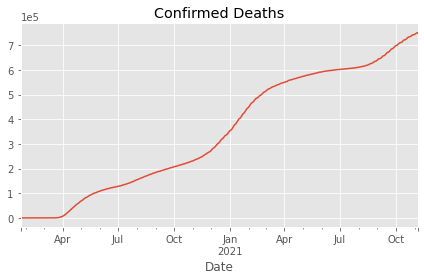

In [9]:
df_date['ConfirmedDeaths'].plot()
plt.title('Confirmed Deaths')
plt.gca().ticklabel_format(style='sci', scilimits=(0, 1), axis='y')
plt.tight_layout()
plt.savefig('ConfirmedDeaths', dpi=300)
plt.show()

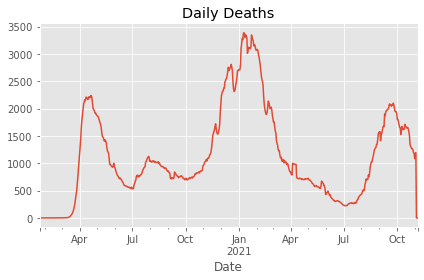

In [10]:
df_date['DailyDeathsMA'].plot()
plt.title('Daily Deaths')
plt.tight_layout()
plt.savefig('DailyDeaths', dpi=300)
plt.show()

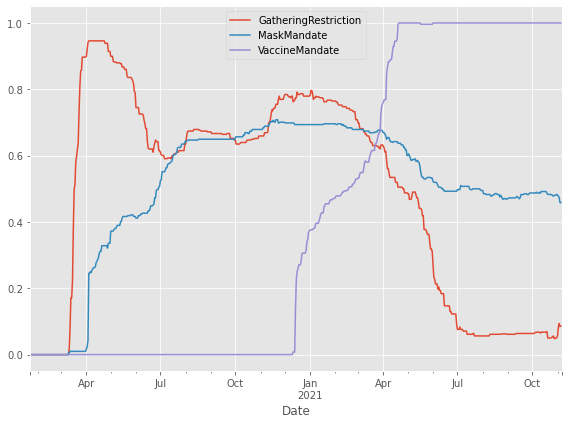

In [11]:
df_date[['GatheringRestriction', 'MaskMandate', 'VaccineMandate']].plot(figsize=(8, 6))
plt.tight_layout()
plt.savefig('Indicators', dpi=300)
plt.show()

## Modeling

### Model 1: Regression on Daily Deaths

Model Features: policies on day $t$

Model Label: deaths on day $t$

In [12]:
df_model = df.dropna(subset=['DailyDeathsMA', 'GatheringRestriction', 'MaskMandate', 'VaccineMandate'])
Y = df_model['DailyDeathsMA'].values
X = df_model[['GatheringRestriction', 'MaskMandate', 'VaccineMandate']]
model = sm.OLS(Y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     567.7
Date:                Wed, 10 Nov 2021   Prob (F-statistic):               0.00
Time:                        19:36:33   Log-Likelihood:            -1.7202e+05
No. Observations:               32736   AIC:                         3.440e+05
Df Residuals:                   32732   BIC:                         3.441e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0667      0.656     -0.102      0.919      -1.353       1.220
GatheringRestriction    17.5103      0.769     22.771      0.000      16.003      19.018
MaskMandate             23.5787      1.216     19.393      0.000      21.196      25.962
VaccineMandate           5.1358      0.681      7.536      0.000       3.800       6.471
==============================================================================
Omnibus:                    42355.960   Durbin-Watson:                   0.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11168633.821
Skew:                           7.142   Prob(JB):                         0.00
Kurtosis:                      92.354   Cond. No.                         6.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 2: Regression on Daily Mortality

Model Features: policies on day $t$

Model Label: mortality (deaths / population) on day $t$

In [13]:
df_model = df.dropna(subset=['DailyDeathsMA', 'GatheringRestriction', 'MaskMandate', 'VaccineMandate'])
Y = (df_model['DailyDeathsMA'] * 1e+7 / df_model['Population']).values
X = df_model[['GatheringRestriction', 'MaskMandate', 'VaccineMandate']]
model = sm.OLS(Y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     887.9
Date:                Wed, 10 Nov 2021   Prob (F-statistic):               0.00
Time:                        19:36:33   Log-Likelihood:            -1.6697e+05
No. Observations:               32736   AIC:                         3.340e+05
Df Residuals:                   32732   BIC:                         3.340e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    8.3675      0.563     14.875      0.000       7.265       9.470
GatheringRestriction     8.4560      0.659     12.830      0.000       7.164       9.748
MaskMandate             39.4131      1.042     37.822      0.000      37.371      41.456
VaccineMandate           0.3095      0.584      0.530      0.596      -0.835       1.454
==============================================================================
Omnibus:                    26142.189   Durbin-Watson:                   0.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           952257.916
Skew:                           3.589   Prob(JB):                         0.00
Kurtosis:                      28.428   Cond. No.                         6.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 3: Regression on Daily Mortality with delay

Model Features: policies on day $t$

Model Label: mortality (deaths number / state population) on day $t + 23$

In [14]:
df_model = df.dropna(subset=['DailyDeathsMA', 'GatheringRestriction', 'MaskMandate', 'VaccineMandate'])
df_model['DeathsDelay'] = np.nan
n_delay_days = 23

region_names = df_model['RegionName'].drop_duplicates()
df_regions = []
for region_name in region_names:
    df_region = df_model[df_model['RegionName'] == region_name]
    df_region['DeathsDelay'][:-n_delay_days] = df_region['DailyDeathsMA'][n_delay_days:].values
    df_regions.append(df_region.dropna(subset=['DeathsDelay']))
df_model = pd.concat(df_regions)

Y = (df_model['DeathsDelay'] * 1e+7 / df_model['Population']).values
X = df_model[['GatheringRestriction', 'MaskMandate', 'VaccineMandate']]
model = sm.OLS(Y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     389.0
Date:                Wed, 10 Nov 2021   Prob (F-statistic):          3.87e-248
Time:                        19:36:34   Log-Likelihood:            -1.6185e+05
No. Observations:               31563   AIC:                         3.237e+05
Df Residuals:                   31559   BIC:                         3.237e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   21.2458      0.580     36.613      0.000      20.108      22.383
GatheringRestriction     2.1915      0.683      3.207      0.001       0.852       3.531
MaskMandate             28.6387      1.075     26.632      0.000      26.531      30.746
VaccineMandate          -7.8215      0.612    -12.787      0.000      -9.020      -6.623
==============================================================================
Omnibus:                    24895.538   Durbin-Watson:                   0.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           839266.196
Skew:                           3.550   Prob(JB):                         0.00
Kurtosis:                      27.243   Cond. No.                         6.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 4: Regression on Daily Mortality Change with delay

Model Features: policies on day $t$

Model Label: mortality change (mortality on day $t + 23$ - mortality on day $t$)

In [15]:
df_model = df.dropna(subset=['DailyDeathsMA', 'GatheringRestriction', 'MaskMandate', 'VaccineMandate'])
df_model['DeathsChangeNum'] = np.nan
n_delay_days = 23

region_names = df_model['RegionName'].drop_duplicates()
df_regions = []
for region_name in region_names:
    df_region = df_model[df_model['RegionName'] == region_name]
    df_region['DeathsChangeNum'][:-n_delay_days] = df_region['DailyDeathsMA'][n_delay_days:].values - df_region['DailyDeathsMA'][:-n_delay_days].values
    df_regions.append(df_region.dropna(subset=['DeathsChangeNum']))
df_model = pd.concat(df_regions)

Y = (df_model['DeathsChangeNum'] * 1e+7 / df_model['Population']).values
X = df_model[['GatheringRestriction', 'MaskMandate', 'VaccineMandate']]
model = sm.OLS(Y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     215.1
Date:                Wed, 10 Nov 2021   Prob (F-statistic):          4.13e-138
Time:                        19:36:34   Log-Likelihood:            -1.5778e+05
No. Observations:               31563   AIC:                         3.156e+05
Df Residuals:                   31559   BIC:                         3.156e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   13.7062      0.510     26.873      0.000      12.707      14.706
GatheringRestriction    -7.5474      0.601    -12.568      0.000      -8.724      -6.370
MaskMandate            -11.1105      0.945    -11.755      0.000     -12.963      -9.258
VaccineMandate          -5.9399      0.538    -11.048      0.000      -6.994      -4.886
==============================================================================
Omnibus:                    15057.565   Durbin-Watson:                   0.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3894131.101
Skew:                           1.112   Prob(JB):                         0.00
Kurtosis:                      57.370   Cond. No.                         6.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 5: Regression on Daily Deaths Change Ratio with delay

Model Features: policies on day $t$

Model Label: deaths change ratio (deaths on day $t + 23$ / deaths on day $t$)

In [16]:
df_model = df.dropna(subset=['DailyDeathsMA', 'GatheringRestriction', 'MaskMandate', 'VaccineMandate'])
df_model['DeathsChangeRatio'] = np.nan
n_delay_days = 23

region_names = df_model['RegionName'].drop_duplicates()
df_regions = []
for region_name in region_names:
    df_region = df_model[df_model['RegionName'] == region_name]
    df_region['DeathsChangeRatio'][:-n_delay_days] = df_region['DailyDeathsMA'][n_delay_days:].values / df_region['DailyDeathsMA'][:-n_delay_days].values
    df_region['DeathsChangeRatio'] = df_region['DeathsChangeRatio'].replace([np.inf, -np.inf], np.nan)
    df_regions.append(df_region.dropna(subset=['DeathsChangeRatio']))
df_model = pd.concat(df_regions)

Y = df_model['DeathsChangeRatio'].values
X = df_model[['GatheringRestriction', 'MaskMandate', 'VaccineMandate']]
model = sm.OLS(Y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     96.84
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           2.34e-62
Time:                        19:36:34   Log-Likelihood:            -1.5083e+05
No. Observations:               28496   AIC:                         3.017e+05
Df Residuals:                   28492   BIC:                         3.017e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   18.7775      0.979     19.181      0.000      16.859      20.696
GatheringRestriction    -4.9760      0.860     -5.785      0.000      -6.662      -3.290
MaskMandate            -19.0745      1.452    -13.133      0.000     -21.921     -16.228
VaccineMandate          -5.7597      0.772     -7.461      0.000      -7.273      -4.247
==============================================================================
Omnibus:                   102973.836   Durbin-Watson:                   0.470
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      50859280399.529
Skew:                          74.870   Prob(JB):                         0.00
Kurtosis:                    6546.123   Cond. No.                         7.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model Diagnostics

We choose model 5 above to be the analysis target.

In [17]:
df_model = df_model[['GatheringRestriction', 'MaskMandate', 'VaccineMandate', 'DeathsChangeRatio', 'Date']].set_index('Date')
df_model.to_csv('df_model.csv')
df_model

,GatheringRestriction,MaskMandate,VaccineMandate,DeathsChangeRatio
Date,,,,
2020-03-22,0.875,0.000,0.0,2.000000
2020-03-23,0.875,0.000,0.0,1.000000
2020-03-24,1.000,0.000,0.0,1.000000
2020-03-25,1.000,0.000,0.0,0.500000
2020-03-26,1.000,0.000,0.0,0.000000
...,...,...,...,...
2021-10-07,0.000,0.375,1.0,0.733333
2021-10-08,0.000,0.375,1.0,1.533333
2021-10-09,0.000,0.375,1.0,1.769231


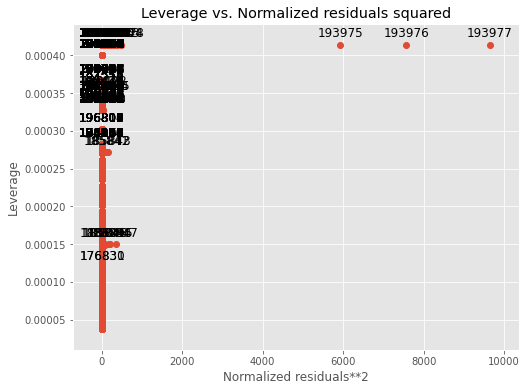

In [18]:
# Residual plot
fig, ax = plt.subplots(figsize=(8, 6))
fig = plot_leverage_resid2(model, ax=ax)

In [19]:
# Multicollinearity

## Condition number of the design matrix
np.linalg.cond(model.model.exog)

7.685552234363899

In [20]:
# Heteroskedasticity tests

## Breush-Pagan test
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(model.resid, model.model.exog)
print('Breush-Pagan test:', lzip(name, test))

## Goldfeld-Quandt test
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
print('Goldfeld-Quandt test:', lzip(name, test))

Breush-Pagan test: [('Lagrange multiplier statistic', 43.84462567860782), ('p-value', 1.6283414356184448e-09), ('f-value', 14.635342014221663), ('f p-value', 1.605899333759209e-09)]
Goldfeld-Quandt test: [('F statistic', 11.625073345771863), ('p-value', 0.0)]
